# ROMY Processing - Prepare masked ZNE streams

Load ZUV data, process, mask with MLTI log and store as masked streams

In [1]:
import os
import obspy as obs
import matplotlib.pyplot as plt
import numpy.ma as ma
import numpy as np

from numpy import where
from andbro__read_sds import __read_sds

from functions.rotate_romy_ZUV_ZNE import __rotate_romy_ZUV_ZNE
from functions.load_lxx import __load_lxx
from functions.load_mlti import __load_mlti
from functions.get_mlti_intervals import __get_mlti_intervals


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/bay200/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'
elif os.uname().nodename == 'lin-ffb-01':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/bay200/'

In [3]:
def __write_stream_to_sds(st, cha, path_to_sds):

    import os

    # check if output path exists
    if not os.path.exists(path_to_sds):
        print(f" -> {path_to_sds} does not exist!")
        return

    tr = st.select(channel=cha)[0]

    nn, ss, ll, cc = tr.stats.network, tr.stats.station, tr.stats.location, tr.stats.channel
    yy, jj = tr.stats.starttime.year, str(tr.stats.starttime.julday).rjust(3,"0")

    if not os.path.exists(path_to_sds+f"{yy}/"):
        os.mkdir(path_to_sds+f"{yy}/")
        print(f"creating: {path_to_sds}{yy}/")
    if not os.path.exists(path_to_sds+f"{yy}/{nn}/"):
        os.mkdir(path_to_sds+f"{yy}/{nn}/")
        print(f"creating: {path_to_sds}{yy}/{nn}/")
    if not os.path.exists(path_to_sds+f"{yy}/{nn}/{ss}/"):
        os.mkdir(path_to_sds+f"{yy}/{nn}/{ss}/")
        print(f"creating: {path_to_sds}{yy}/{nn}/{ss}/")
    if not os.path.exists(path_to_sds+f"{yy}/{nn}/{ss}/{cc}.D"):
        os.mkdir(path_to_sds+f"{yy}/{nn}/{ss}/{cc}.D")
        print(f"creating: {path_to_sds}{yy}/{nn}/{ss}/{cc}.D")

    st.write(path_to_sds+f"{yy}/{nn}/{ss}/{cc}.D/"+f"{nn}.{ss}.{ll}.{cc}.D.{yy}.{jj}", format="MSEED")

    print(f" -> stored stream as: {yy}/{nn}/{ss}/{cc}.D/{nn}.{ss}.{ll}.{cc}.D.{yy}.{jj}")

In [4]:
def __mlti_intervals_to_zero(dat, times, mlti_t1, mlti_t2, t_offset_sec=120):

    from numpy import nan, where, full, array

    dat = array(dat)

    mask = full((len(times)), 0, dtype=int)

    idx = 0
    for nn, tt in enumerate(times):

        if idx >= len(mlti_t1):
            continue
        else:
            t1, t2 = (mlti_t1[idx]-t_offset_sec), (mlti_t2[idx]+t_offset_sec)

        if tt >= t1:
            mask[nn] = 1
        if tt > t2:
            idx += 1

    dat = where(mask == 1, 1, dat)

    return dat

In [5]:
def __get_trace(seed):

    from numpy import zeros

    net, sta, loc, cha = seed.split('.')

    trr = obs.Trace()
    trr.stats.starttime = config['t1']
    trr.data = zeros(config['Nexpected'])
    trr.stats.network = net
    trr.stats.station = sta
    trr.stats.location = loc
    trr.stats.channel = cha
    trr.stats.sampling_rate = config['sampling_rate']

    return trr

## Configurations

In [6]:
config = {}

config['path_to_sds'] = archive_path+"romy_archive/"

config['path_to_sds_out'] = archive_path+"temp_archive/"

config['path_to_inventory'] = root_path+"Documents/ROMY/stationxml_ringlaser/dataless/"

config['path_to_figs'] = root_path+"Downloads/tmp/testfigs/"

# config['tbeg'] = obs.UTCDateTime("2024-05-25")
# config['tbeg'] = obs.UTCDateTime("2024-06-26")
config['tbeg'] = obs.UTCDateTime("2024-07-11")
config['tend'] = config['tbeg'] + 86400

config['sampling_rate'] = 20 # Hz

config['time_offset'] = 60 # seconds

config['t1'] = config['tbeg']-config['time_offset']
config['t2'] = config['tend']+config['time_offset']

config['Nexpected'] = int((config['t2'] - config['t1']) * config['sampling_rate'])


## Load Data

In [7]:
# load MLTI logs
mltiU = __load_mlti(config['t1'], config['t2'], "U", archive_path)
mltiV = __load_mlti(config['t1'], config['t2'], "V", archive_path)
mltiZ = __load_mlti(config['t1'], config['t2'], "Z", archive_path)

# load maintenance file
lxx = __load_lxx(config['t1'], config['t2'], archive_path)


### Load inventory

In [8]:
romy_inv = obs.read_inventory(config['path_to_inventory']+"dataless.seed.BW_ROMY")

### Load rotation data

In [168]:
st0 = obs.Stream()

st0 += __read_sds(config['path_to_sds'], "BW.ROMY.10.BJZ", config['t1'], config['t2'])
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJU", config['t1'], config['t2'])
st0 += __read_sds(config['path_to_sds'], "BW.ROMY..BJV", config['t1'], config['t2'])

# remove sensitivity
st0 = st0.remove_sensitivity(romy_inv)

print(st0)

# check if merging is required
if len(st0) > 3:
    print(f" -> merging required!")
    st0.merge(fill_value="interpolate")

print(st0)

# remove trend
st0 = st0.detrend("linear")

# check if data has same length
for tr in st0:
    Nreal = len(tr.data)
    if Nreal != config['Nexpected']:
        tr.data = tr.data[:config['Nexpected']]
        # print(f" -> adjust length: {tr.stats.station}.{tr.stats.channel}:  {Nreal} -> {config['Nexpected']}")

st0 = __rotate_romy_ZUV_ZNE(st0, romy_inv, keep_z=True)

# st0 = st0.trim(config['tbeg'], config['tend'])

st0

7 Trace(s) in Stream:
BW.ROMY.10.BJZ | 2024-07-10T23:58:59.979199Z - 2024-07-12T00:00:59.979199Z | 20.0 Hz, 1730401 samples
BW.ROMY..BJU   | 2024-07-10T23:58:59.989999Z - 2024-07-11T09:17:17.439999Z | 20.0 Hz, 669950 samples
BW.ROMY..BJU   | 2024-07-11T09:17:19.502599Z - 2024-07-11T12:47:02.652599Z | 20.0 Hz, 251664 samples
BW.ROMY..BJU   | 2024-07-11T12:47:04.706600Z - 2024-07-11T17:40:41.206600Z | 20.0 Hz, 352331 samples
BW.ROMY..BJU   | 2024-07-11T17:40:43.256999Z - 2024-07-11T21:31:24.756999Z | 20.0 Hz, 276831 samples
BW.ROMY..BJU   | 2024-07-11T21:31:26.821001Z - 2024-07-12T00:00:59.971001Z | 20.0 Hz, 179464 samples
BW.ROMY..BJV   | 2024-07-10T23:58:59.978000Z - 2024-07-12T00:00:59.978000Z | 20.0 Hz, 1730401 samples
 -> merging required!


3 Trace(s) in Stream:
BW.ROMY..BJU   | 2024-07-10T23:58:59.989999Z - 2024-07-12T00:00:59.989999Z | 20.0 Hz, 1730401 samples
BW.ROMY..BJV   | 2024-07-10T23:58:59.978000Z - 2024-07-12T00:00:59.978000Z | 20.0 Hz, 1730401 samples
BW.ROMY.10.BJZ | 2024-07-10T23:58:59.979199Z - 2024-07-12T00:00:59.979199Z | 20.0 Hz, 1730401 samples

3 Trace(s) in Stream:
BW.ROMY..BJU   | 2024-07-10T23:58:59.989999Z - 2024-07-12T00:00:59.989999Z | 20.0 Hz, 1730401 samples
BW.ROMY..BJV   | 2024-07-10T23:58:59.978000Z - 2024-07-12T00:00:59.978000Z | 20.0 Hz, 1730401 samples
BW.ROMY.10.BJZ | 2024-07-10T23:58:59.979199Z - 2024-07-12T00:00:59.979199Z | 20.0 Hz, 1730401 samples


3 Trace(s) in Stream:
BW.ROMY..BJN   | 2024-07-10T23:58:59.989999Z - 2024-07-12T00:00:59.939999Z | 20.0 Hz, 1730400 samples
BW.ROMY..BJE   | 2024-07-10T23:58:59.978000Z - 2024-07-12T00:00:59.928000Z | 20.0 Hz, 1730400 samples
BW.ROMY.10.BJZ | 2024-07-10T23:58:59.979199Z - 2024-07-12T00:00:59.929199Z | 20.0 Hz, 1730400 samples

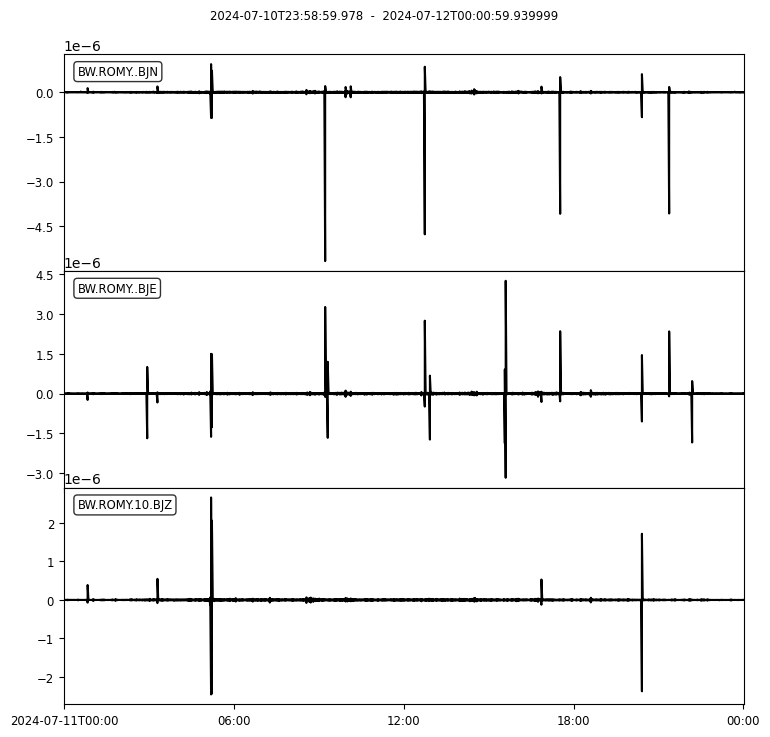

In [169]:
st0.plot(equal_scale=False);

### Load MLTI log

In [11]:
mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)
mltiV_t1, mltiV_t2 = __get_mlti_intervals(mltiV.time_utc)
mltiZ_t1, mltiZ_t2 = __get_mlti_intervals(mltiZ.time_utc)

#### use MLTI log as filter

In [12]:
tr_mltiU = __get_trace("BW.ROMY.30.MLT")

tr_mltiU.data = __mlti_intervals_to_zero(tr_mltiU.data,
                                         tr_mltiU.times(reftime=config['t1'], type="utcdatetime"),
                                         mltiU_t1,
                                         mltiU_t2,
                                         t_offset_sec=30
                                         )

In [13]:
tr_mltiV = __get_trace("BW.ROMY.30.MLT")

tr_mltiV.data = __mlti_intervals_to_zero(tr_mltiV.data,
                                         tr_mltiV.times(reftime=config['t1'], type="utcdatetime"),
                                         mltiV_t1,
                                         mltiV_t2,
                                         t_offset_sec=30
                                         )

In [14]:
tr_mltiZ = __get_trace("BW.ROMY.30.MLT")

tr_mltiZ.data = __mlti_intervals_to_zero(tr_mltiZ.data,
                                         tr_mltiZ.times(reftime=config['t1'], type="utcdatetime"),
                                         mltiZ_t1,
                                         mltiZ_t2,
                                         t_offset_sec=30
                                         )

### Load maintenance log

In [15]:
lxx_t1, lxx_t2 = __get_mlti_intervals(lxx.datetime)

#### use maintenance log as filter

In [16]:
tr_lxx = __get_trace("BW.ROMY.30.LXX")

tr_lxx.data = __mlti_intervals_to_zero(tr_lxx.data,
                                       tr_lxx.times(reftime=config['t1'], type="utcdatetime"),
                                       lxx_t1,
                                       lxx_t2,
                                       t_offset_sec=60
                                       )

In [17]:
# make mlti trace for horizontals (since rotated and intermixed)
tr_mltiH = tr_mltiU.copy()

# combine mlti periods
tr_mltiH.data = tr_mltiU.data + tr_mltiV.data

# remove periods with value 2 due to summation
tr_mltiH.data = where(tr_mltiH.data >= 1, 1, tr_mltiH.data)

In [18]:
# plt.plot(tr_mltiU.data)
# plt.plot(tr_mltiV.data)
# plt.plot(tr_mltiH.data)

In [19]:
# Z = st0.select(channel="*E")[0].data

# plt.figure()
# plt.plot(tr_mltiH.data)
# plt.plot(tr_lxx.data)

# plt.plot(Z)
# plt.ylim(-max(abs(Z)), max(abs(Z)))
# plt.show()

### Remove Spikes

In [25]:
%matplotlib tk

In [21]:
def despike_sta_lta(arr, df, t_lta=50, t_sta=1, threshold_upper=40, plot=False):

    from obspy.signal.trigger import recursive_sta_lta
    from obspy.signal.trigger import classic_sta_lta
    from obspy.signal.trigger import plot_trigger
    import numpy as np

    def smooth(y, npts):
        '''
        moving average of 1d signal for n samples
        '''
        win = np.hanning(npts)
        y_smooth = np.convolve(y, win/np.sum(win), mode='same')
        y_smooth[:npts//2] = np.nan
        y_smooth[-npts//2:] = np.nan
        return y_smooth

    # apply sta lta
    # cft = classic_sta_lta(arr, int(t_sta * df), int(t_lta * df))

    cft = recursive_sta_lta(arr, int(t_sta * df), int(t_lta * df))

    # plot trigger result
    if plot:
        plot_trigger(tr, cft, threshold_upper, 1, show=plot)

    # create mask from triggers
    spikes = np.where(cft < threshold_upper, 0, cft)
    spikes = np.where(spikes > threshold_upper, 1, spikes)

    # create mask with nan
    mask2 = where(spikes == 1, np.nan, spikes)
    mask2 += 1

    mask2 = smooth(mask2, 20)

    mask1 = np.nan_to_num(mask2, nan=0)

    return spikes, mask1, mask2

In [177]:
spikes = {}
masks = {}

# st01 = st0.copy()
# st01 = st01.detrend("linear").taper(0.01, type="cosine")
# st01 = st01.filter("lowpass", freq=1, corners=4, zerophase=True);

for tr in st0:

    df = tr.stats.sampling_rate

    cha = tr.stats.channel[-1]

    data = tr.copy().data

    _data = tr.copy().data

    spikes[cha] = np.zeros(_data.size)
    masks[cha] = np.ones(_data.size)

    for i in range(100):

        # detect spikes
        _spikes, mask1, mask2 = despike_sta_lta(_data, df, t_lta=50, t_sta=1, threshold_upper=30, plot=False)

        # stop if no more spikes are detected
        if any(_sp >= 1 for _sp in _spikes):
            # apply mask
            # _data *= mask1
            _data *= mask1

            # add detected spikes
            spikes[cha] += _spikes

            # add detected spikes
            masks[cha] *= mask1

        else:
            print(f" -> stopped despiking!\n    {cha}: iteration={i}  spikes={int(sum(spikes[cha]))}")
            break

    print(f" -> finished despiking!\n    {cha}: iteration={i}  spikes={int(sum(spikes[cha]))}")

    # normalize to one (avoid accumulation)
    spikes[cha] = np.where(spikes[cha] > 1, 1, spikes[cha])

 -> stopped despiking!
    N: iteration=4  spikes=121
 -> finished despiking!
    N: iteration=4  spikes=121
 -> stopped despiking!
    E: iteration=6  spikes=407
 -> finished despiking!
    E: iteration=6  spikes=407
 -> stopped despiking!
    Z: iteration=4  spikes=95
 -> finished despiking!
    Z: iteration=4  spikes=95


In [178]:
def __checkup_plot():

    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(15, 12))

    plt.subplots_adjust(hspace=0.15)

    for i, tr in enumerate(st0):

        cha = tr.stats.channel[-1]

        data_before = tr.copy().data
        data_after = data_before*masks[cha]

        ax[i].plot(spikes[tr.stats.channel[-1]], color="grey", alpha=0.6, zorder=1, label="spikes")
        ax[i].plot(data_before, label=f"{cha} before")
        ax[i].plot(data_after, label=f" {cha} after")

        ax[i].set_ylim(-np.nanmax(abs(data_after))*1.1, np.nanmax(abs(data_after))*1.1)

        ax[i].legend(loc=1)

    plt.show();
    return fig

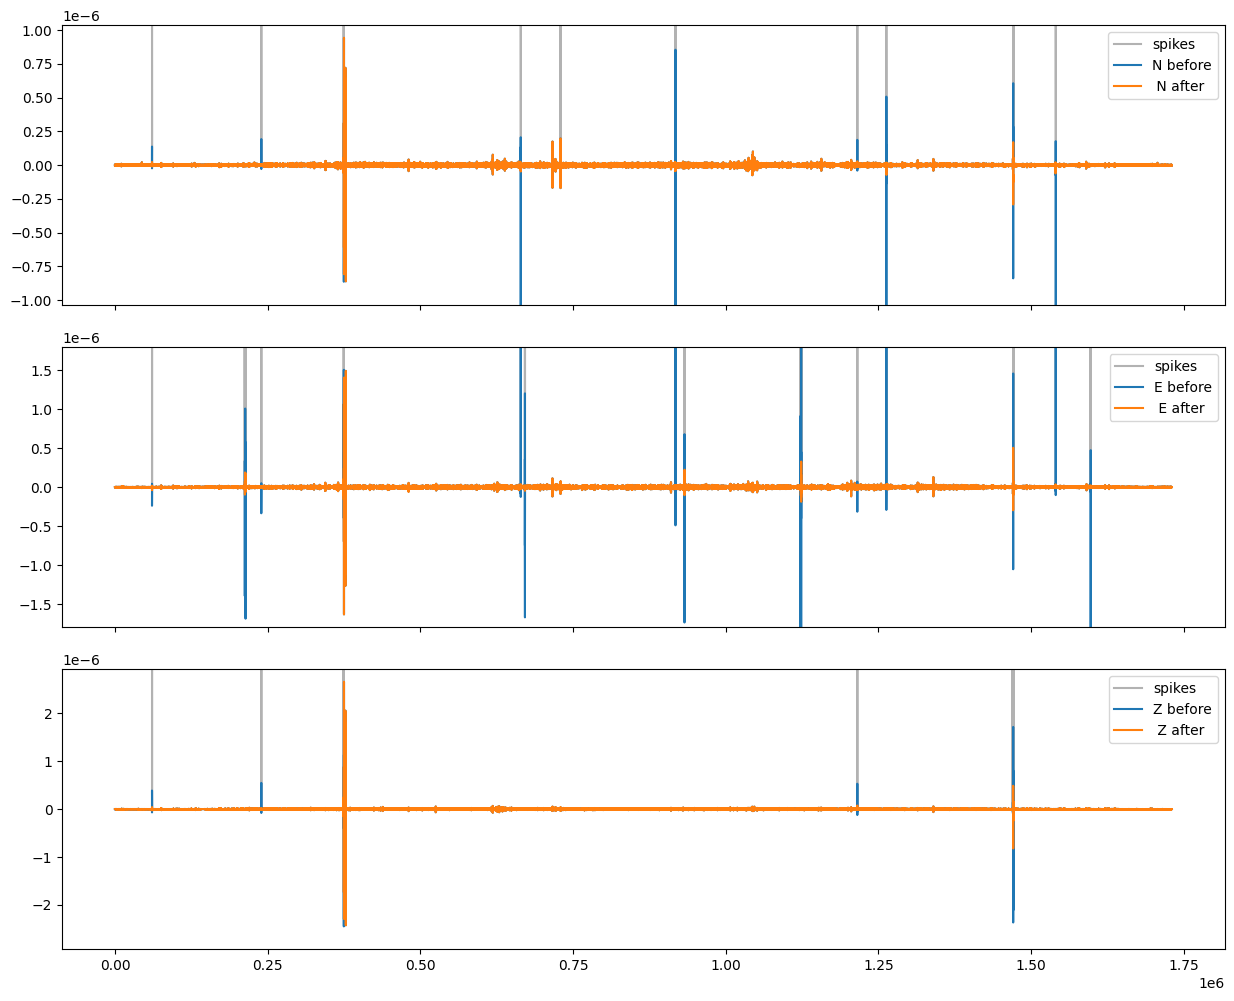

In [179]:
fig = __checkup_plot()

# fig.savefig(config['path_to_figs']+f"{config['tbeg'].date}.png", format="png", dpi=150, bbox_inches='tight')

del fig

## Write Data

In [180]:
# outZ = obs.Stream()

# outZ += st0.select(component="Z").copy()
# outZ.select(component="Z")[0].stats.location = "30"
# outZ += tr_mltiZ.copy()
# outZ += tr_lxx.copy()

# outZ = outZ.trim(config['tbeg'], config['tend'], nearest_sample=False)

# # __write_stream_to_sds(outZ, "BJZ", config['path_to_sds_out'])


In [181]:
# outN = obs.Stream()

# outN += st0.select(component="N").copy()
# outN.select(component="N")[0].stats.location = "30"
# outN += tr_mltiH.copy()
# outN += tr_lxx.copy()

# outN = outN.trim(config['tbeg'], config['tend'], nearest_sample=False)

# # __write_stream_to_sds(outN, "BJN", config['path_to_sds_out'])


In [182]:
# outE = obs.Stream()

# outE += st0.select(component="E").copy()
# outE.select(component="E")[0].stats.location = "30"
# outE += tr_mltiH.copy()
# outE += tr_lxx.copy()

# outE = outE.trim(config['tbeg'], config['tend'], nearest_sample=False)

# # __write_stream_to_sds(outE, "BJE", config['path_to_sds_out'])


## Option 2

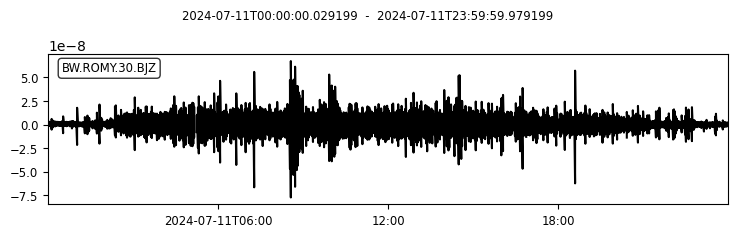

In [183]:
outZ = obs.Stream()

outZ += st0.select(component="Z").copy()
outZ.select(component="Z")[0].stats.location = "30"

data = outZ.select(component="Z")[0].data
mask = tr_mltiZ.data

if len(data) != len(mask):
    mask = mask[:len(data)]

# apply mlti mask
dat1 = ma.masked_array(data, mask=mask)

# apply spikes mask
dat2 = ma.masked_array(dat1, mask=spikes["Z"])

# overwrite data
outZ.select(component="Z")[0].data = dat2

# trim to defined interval
outZ = outZ.trim(config['tbeg'], config['tend'], nearest_sample=False)

outZ = outZ.split()

# __write_stream_to_sds(outZ, "BJZ", config['path_to_sds_out'])

outZ.plot();

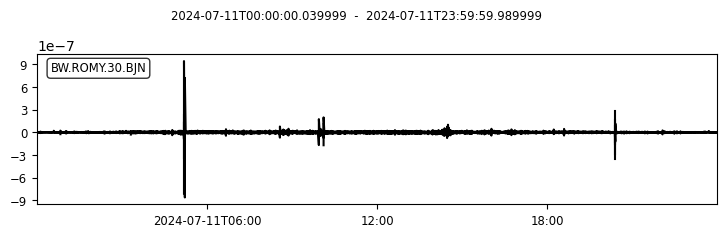

In [184]:
outN = obs.Stream()

outN += st0.select(component="N").copy()
outN.select(component="N")[0].stats.location = "30"

data = outN.select(component="N")[0].data
mask = tr_mltiH.data

if len(data) != len(mask):
    mask = mask[:len(data)]

# apply mlti mask
dat1 = ma.masked_array(data, mask=mask)

# apply spikes mask
dat2 = ma.masked_array(dat1, mask=spikes["N"])

# overwrite data
outN.select(component="N")[0].data = dat2

# trim to defined interval
outN = outN.trim(config['tbeg'], config['tend'], nearest_sample=False)

outN = outN.split()

# __write_stream_to_sds(outN, "BJN", config['path_to_sds_out'])

outN.plot();

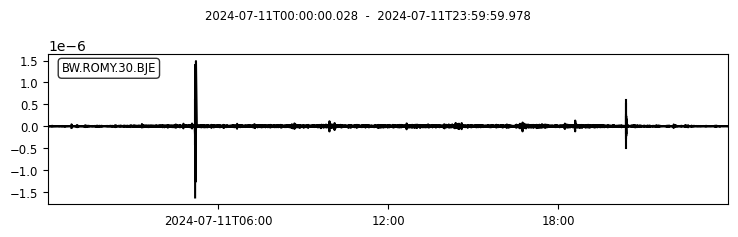

In [185]:
outE = obs.Stream()

outE += st0.select(component="E").copy()
outE.select(component="E")[0].stats.location = "30"

data = outE.select(component="E")[0].data
mask = tr_mltiH.data

if len(data) != len(mask):
    mask = mask[:len(data)]

# apply mlti mask
dat1 = ma.masked_array(data, mask=mask)

# apply spikes mask
dat2 = ma.masked_array(dat1, mask=spikes["E"])

# overwrite data
outE.select(component="E")[0].data = dat2


outE = outE.trim(config['tbeg'], config['tend'], nearest_sample=False)

outE = outE.split()

# __write_stream_to_sds(outE, "BJE", config['path_to_sds_out'])

outE.plot();

In [186]:
# config['t1'] = obs.UTCDateTime("2024-07-01")
# config['t2'] = config['tbeg'] + 86400

# st0 = obs.Stream()

# config['path_to_sds'] = archive_path+"temp_archive/"

# st0 += __read_sds(config['path_to_sds'], "BW.ROMY.30.BJZ", config['t1'], config['t2'])
# st0 += __read_sds(config['path_to_sds'], "BW.ROMY.30.BJN", config['t1'], config['t2'])
# st0 += __read_sds(config['path_to_sds'], "BW.ROMY.30.BJE", config['t1'], config['t2'])

# st0.merge(fill_value=0)

# st0.plot();

In [187]:
t1 = obs.UTCDateTime("2024-07-11 15:08:00")
t2 = obs.UTCDateTime("2024-07-11 16:38:00")

# t1 = obs.UTCDateTime("2024-07-11 02:13:00")
# t2 = obs.UTCDateTime("2024-07-11 03:12:00")

In [188]:
stt = outZ.copy()
stt += outN.copy()
stt += outE.copy()

stt = stt.trim(t1-7200, t2)

stt = stt.detrend("linear").taper(0.01, type="cosine")
# stt = stt.filter("bandpass", freqmin=0.001, freqmax=0.1, corners=4, zerophase=True);
stt = stt.filter("lowpass", freq=1, corners=4, zerophase=True);

stt.merge(fill_value=0)

3 Trace(s) in Stream:
BW.ROMY.30.BJE | 2024-07-11T13:07:59.978000Z - 2024-07-11T16:37:59.978000Z | 20.0 Hz, 252001 samples
BW.ROMY.30.BJN | 2024-07-11T13:07:59.989999Z - 2024-07-11T16:37:59.989999Z | 20.0 Hz, 252001 samples
BW.ROMY.30.BJZ | 2024-07-11T13:07:59.979199Z - 2024-07-11T16:37:59.979199Z | 20.0 Hz, 252001 samples

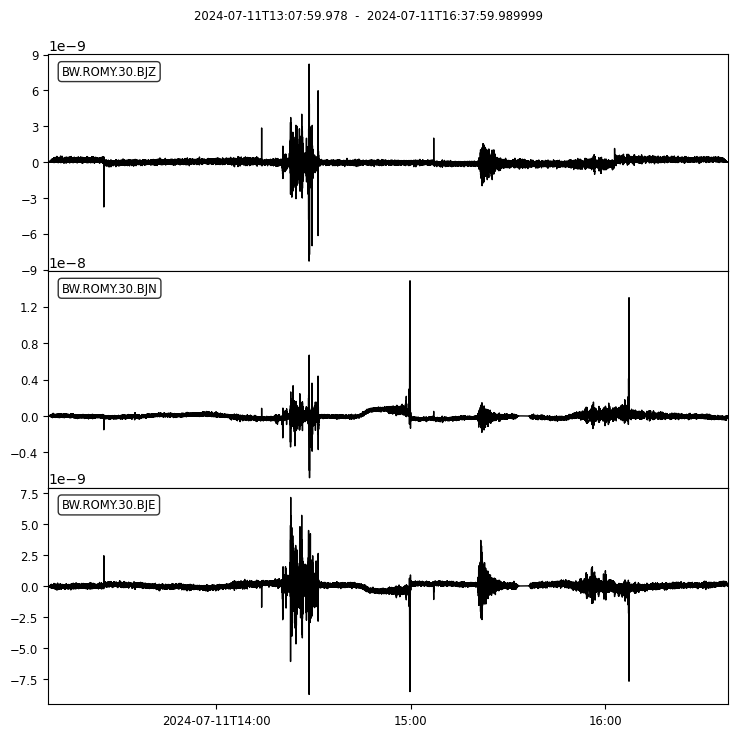

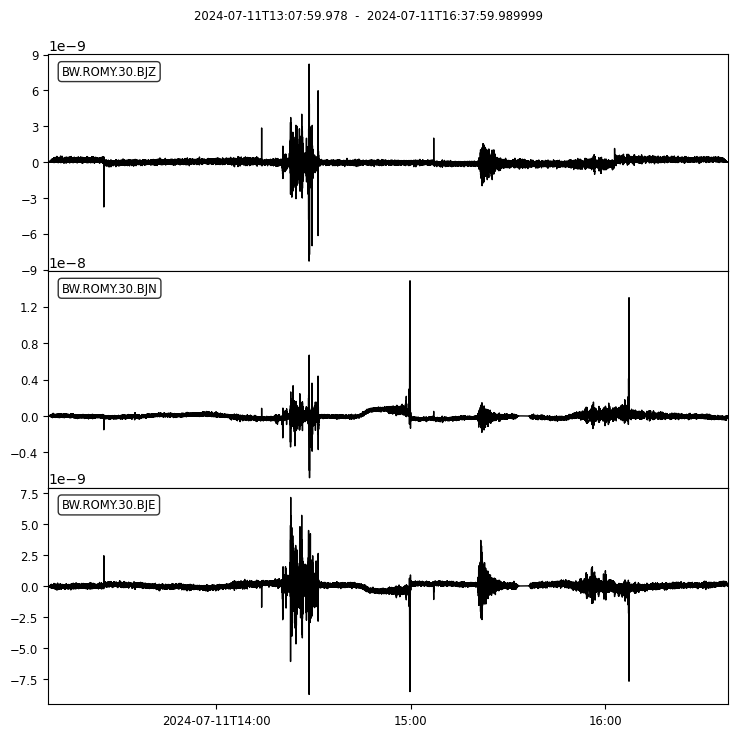

In [189]:
stt.plot(equal_scale=False)

In [190]:
from scipy.signal import find_peaks, hilbert, peak_prominences


[ 87010  87021  87131  87986  88153  88165  88179  89807  89840  89852
  89890  89910  89959  90012  90078  90320  90333  90354  90377  90484
  90549  90568  90651  90715  90725  90737  90783  90795  90834  90900
  91355  91503  91553  91564  91581  91593  91700  91743  91988  92026
  92179  92191  92213  92319  92331  92342  92355  92427  92479  92491
  92514  93053  93066  93149  93189  93200  93211  93221  93263  93273
  93369  93388  93398  93408  93426  93495  93532  93633  93745  93820
  93868  93909  93932  93971  94002  94015  94032  94090  94112  94124
  94167  94189  94280  94293  94352  94419  94529  94626  95672  95721
  95733  95746  95764  95775  96248  96260  96289  96383  96429  96439
  96449  96461  96473  96514  96763  96791  96838  96849  97116  97217
  97243  97256  97317  97328  97346  97357  97530  97563  97575  97585
  97609  97639  97655  97694  97726  97772  97794  97841  98043  98072
  98166  98194  98217  98503  98725  98993  99008  99279  99312  99324
  9937

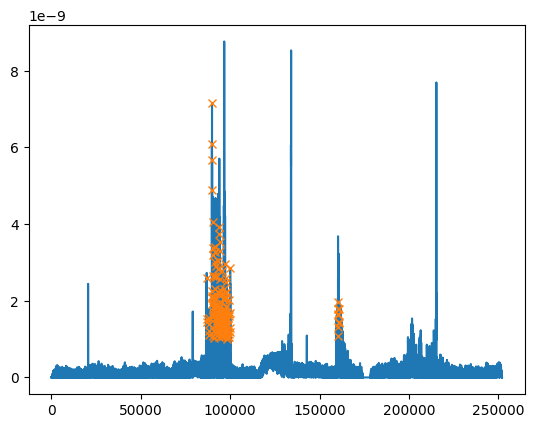

In [38]:
x = abs(stt.select(channel="*E")[0].data)

peaks, _ = find_peaks(x, height=1e-9, prominence=1e-9, width=(None, 10))
print(peaks)

prominences = peak_prominences(x, peaks)[0]

contour_heights = x[peaks] - prominences

plt.plot(x)

plt.plot(peaks, x[peaks], "x")

plt.show()

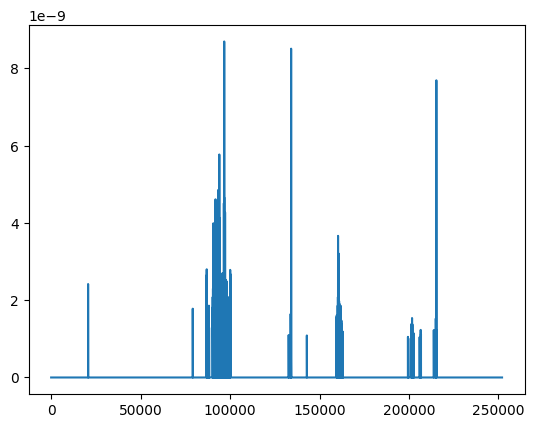

In [464]:
prom = np.zeros(len(x))
n = 0
for idx in peaks:
    if idx > 0:
        prom[idx] = prominences[n]
        n += 1
plt.plot(prom)

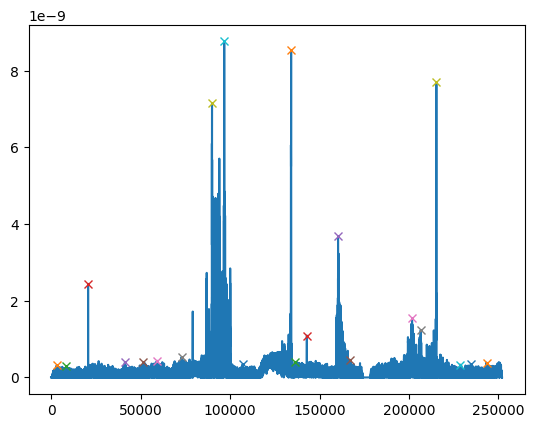

In [128]:
from peakdetect import peakdetect

x = abs(stt.select(channel="*E")[0].data)

peaks = peakdetect(x, lookahead=20*300, delta=0)

plt.plot(x)

for _x, _y in peaks[0]:
    plt.plot(_x, _y, "x")

plt.show();

[ 89921  90257  93273  93379  93398  94100  96716  96763  97667  97761
 100010]


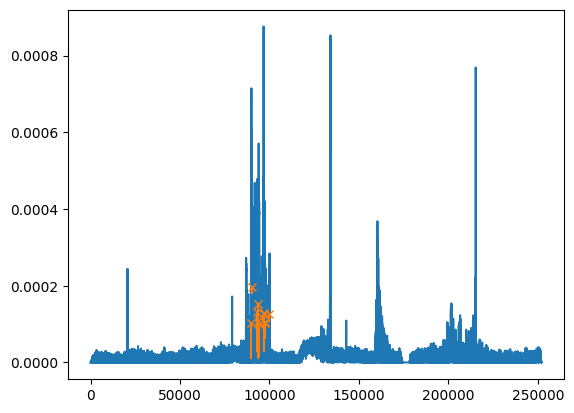

In [126]:

data = stt.select(channel="*E")[0].data

x = abs(stt.select(channel="*E")[0].data)
x = x / 1e-5

time = stt.select(channel="*E")[0].times()

peaks, properties = find_peaks(x, height=1e-4, distance=5, width=(1, 5), prominence=1e-5)
print(peaks)

# print(properties["prominences"].min(), properties["prominences"].max())

plt.plot(x)

# plt.plot(abs(hilbert(x)))

plt.plot(peaks, x[peaks], "x")

plt.vlines(x=peaks, ymin=x[peaks] - properties["prominences"],
           ymax = x[peaks], color = "C1")

plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
           xmax=properties["right_ips"], color = "C1")

plt.show();

In [129]:
for pk in peaks:
    for i in range(100):
        data[pk-i] = np.nan
        data[pk+i] = np.nan

plt.plot(time, data)



TypeError: unsupported operand type(s) for -: 'list' and 'int'

0


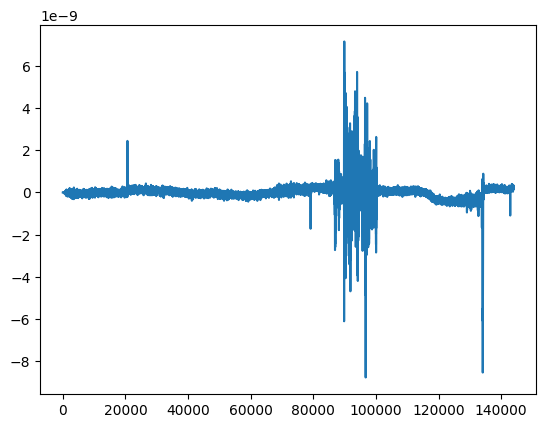

In [165]:
import numpy as np
from scipy import signal

data = stt.select(channel="*E")[0].copy().data[:2*3600*20]
time = stt.select(channel="*E")[0].copy().times()[:2*3600*20]

plt.plot(data)

pkidx = signal.find_peaks_cwt(  data,
                                np.arange(1, 2001, 20),
                                wavelet=None,
                                max_distances=None,
                                gap_thresh=10,
                                min_length=100,
                                min_snr=1,
                                noise_perc=10,
                                window_size=None,
                                )

print(pkidx.size)

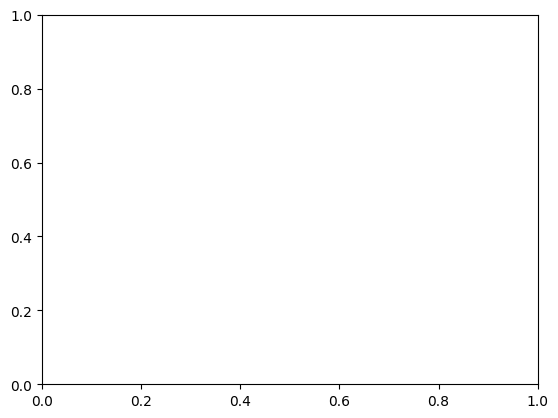

In [166]:
plt.vlines(pkidx, -1, 1)

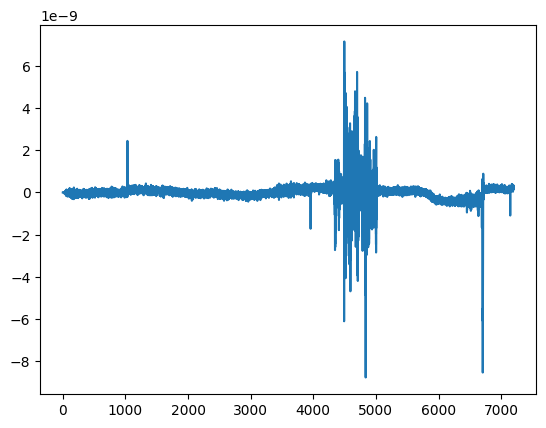

In [167]:
for pk in pkidx:
    plt.axvline(time[pk], -max(abs(data)), max(abs(data)))

n_cut = 100
for pk in pkidx:
    if pk + n_cut < len(data):
        for i in range(n_cut):
            data[pk-i] = np.nan
            data[pk+i] = np.nan

plt.plot(time, data)

plt.show();

In [423]:
def __compute_cwt(times, arr1, tdelta, datalabel="dat1", log=False, period=False, tscale='sec', scale_value=2, ymax=None, normalize=True, plot=True):

    from pycwt import wct, xwt, Morlet, ar1, significance, cwt
    from numpy import std, nanmean, nan, nansum, nanmax, nanmin, nanvar, ones, nan_to_num, polyfit, polyval, array, reshape, nanpercentile
    import matplotlib.pyplot as plt
    from numpy import sum as npsum

    times = array(times, dtype='float64')
    arr1 = array(arr1, dtype='float64')

    if len(arr1) != len(arr1):
        print(" -> different lenght of arrays!")
        return

    def __mask_cone(arr2d, ff, thresholds, fill=nan):
        mask = ones(arr2d.shape)
        for k in range(arr2d.shape[0]):  ##85
            for l in range(arr2d.shape[1]):  ## 1401
                 if ff[k] < thresholds[l]:
                    mask[k,l] = fill
        return mask


    ## specify parameters
    N = len(arr1)
    dt = tdelta
    df = 1/dt
    significance_threshold = 0.95

    ## detrend data
    p = polyfit(times - times[0], arr1, 1)
    dat_notrend = arr1 - polyval(p, times - times[0])
    std = dat_notrend.std()  # Standard deviation
    var = std ** 2  # Variance
    arr1 = dat_notrend / std  # Normalized dataset

    ## create mother wavelet
    mother_wavelet = Morlet(6)
    s0_set = scale_value * dt  # Starting scale
    dj_set = 1 / 12  # Twelve sub-octaves per octaves
    J_set = int(7 / dj_set)  # Seven powers of two with dj sub-octaves
    #print(s0_set, dj_set, J_set)


    cwt, scales, ff_cwt, cone_p, fft, fftfreqs = cwt(
                                                        arr1,
                                                        dt=dt,
                                                        dj=dj_set, #0.05,
                                                        s0=s0_set, #-1,
                                                        J=J_set, #-1,
                                                        wavelet=mother_wavelet,  # u'morlet',
                                                    )

    cone_f = 1/cone_p
    pp_cwt = 1/ff_cwt

    if tscale == "min":
        times /= 60
        cone_p /= 60
        pp_cwt /= 60
        unit = "min"
    elif tscale == "hour":
        times /= 3600
        cone_p /= 3600
        pp_cwt /= 3600
        unit = "hour"
    else:
        unit = "s"

    ## building cone
    mask_cone = __mask_cone(cwt, ff_cwt, cone_f, fill=nan)


    ## get real part
    cwt_power = abs(cwt)

    ## normalize cross wavelet transform
    if normalize:
        cwt_power /= nanmax(cwt_power.reshape((1, cwt_power.size))[0])

    ## apply masks
    # cwt_power_masked = cwt_power * mask_cwt * mask_cone
    cwt_power_masked = cwt_power * mask_cone

    ## compute global cross wavelet transform power
    global_mean_cwt_f = nanmean(cwt_power_masked, axis=1)
    global_sum_cwt_f = nansum(cwt_power_masked, axis=1)

    # if normalize:
    #     global_sum_cwt_f /= max(global_sum_cwt_f)
    #     global_mean_cwt_f /= max(global_mean_cwt_f)


    ## ____________________________________________________
    ## plotting
    if plot:

        from mpl_toolkits.axes_grid1 import make_axes_locatable

        import matplotlib.pyplot as plt
        from matplotlib.gridspec import GridSpec

        Ncol, Nrow = 4, 3

        font = 12

        fig = plt.figure(figsize=(15, 8))

        gs = GridSpec(Nrow, Ncol, figure=fig)

        ax1 = fig.add_subplot(gs[0, :-1])
        ax2 = fig.add_subplot(gs[1:, :-1])
        ax3 = fig.add_subplot(gs[1:, 3:])

        ax1.set_xticklabels([])
        ax3.set_yticklabels([])

        plt.subplots_adjust(hspace=0.1, wspace=0.1)


        ax1.plot(times, arr1, alpha=1, color="black", lw=1, label=datalabel)

        ax1.set_xlim(min(times), max(times))
        ax1.set_ylabel("Amplitude", fontsize=font)
        ax1.legend(loc=1)



        if period:
            if log:
                ca2 = ax2.pcolormesh(
                                    times,
                                    pp_cwt,
                                    cwt_power,
                                    vmin=nanpercentile(reshape(cwt_power, cwt_power.size), 1),
                                    vmax=nanpercentile(reshape(cwt_power, cwt_power.size), 99),
                                    rasterized=True,
                                    norm="log",
                                    )
            else:
                ca2 = ax2.pcolormesh(
                                    times,
                                    pp_cwt,
                                    cwt_power,
                                    vmin=nanpercentile(reshape(cwt_power, cwt_power.size), 1),
                                    vmax=nanpercentile(reshape(cwt_power, cwt_power.size), 99),
                                    rasterized=True,
                                    )

            ax3.plot(global_mean_cwt_f, pp_cwt, color="black", label="global mean power")

            ax33 = ax3.twiny()
            ax33.plot(global_sum_cwt_f, pp_cwt, color="darkred", label="global sum power")

        else:
            if log:
                ca2 = ax2.pcolormesh(
                                    times,
                                    ff_cwt,
                                    cwt_power,
                                    vmin=nanpercentile(reshape(cwt_power, cwt_power.size), 1),
                                    vmax=nanpercentile(reshape(cwt_power, cwt_power.size), 99),
                                    rasterized=True,
                                    norm="log"
                                    )
            else:
                ca2 = ax2.pcolormesh(
                                    times,
                                    ff_cwt,
                                    cwt_power,
                                    vmin=nanpercentile(reshape(cwt_power, cwt_power.size), 1),
                                    vmax=nanpercentile(reshape(cwt_power, cwt_power.size), 99),
                                    rasterized=True,
                                    )


            ax3.plot(global_mean_cwt_f, ff_cwt, color="black", label="global mean power")

            ax33 = ax3.twiny()
            ax33.plot(global_sum_cwt_f, ff_cwt, color="darkred", label="global sum power")

        if period:
            ax2.plot(times, cone_p, color="white", ls="--")
            ax2.fill_between(times, cone_p, max(pp_cwt), color="white", alpha=0.2)
            ax2.set_ylabel(f"Period ({unit})", fontsize=font)
        else:
            ax2.plot(times, cone_f, color="white")
            ax2.fill_between(times, cone_f, min(ff_cwt), color="white", alpha=0.2)
            ax2.set_ylabel("Frequency (Hz)", fontsize=font)
            ax3.set_xlabel("Frequency (Hz)", fontsize=font)

        # ax3.legend()
        ax3.set_xlabel("global mean power", fontsize=font)
        ax33.set_xlabel("global sum power", fontsize=font, color="darkred")
        ax33.tick_params(axis='x', labelcolor="darkred")
        ax2.set_xlabel(f"Time ({unit})", fontsize=font)


        ## add colorbar
        cbar_ax = fig.add_axes([0.73, 0.75, 0.17, 0.08]) #[left, bottom, width, height]
        cb = plt.colorbar(ca2, cax=cbar_ax, orientation="horizontal", extend="both")
        cb.set_label("CWT power", fontsize=font, color="black")



        if ymax is not None:
            print(f"set frequency limit: {ymax}")
            if period:
                ax3.set_xlim(0, ymax)
                ax2.set_ylim(0, ymax)
            else:
                ax3.set_xlim(0, ymax)
                ax2.set_ylim(0, ymax)
        else:
            if period:
                ax2.set_ylim(min(pp_cwt), max(pp_cwt))
            else:
                ax2.set_ylim(min(ff_cwt), max(ff_cwt))



        plt.show();

    ## prepare dict for return
    out = {}
    out['times'] = times
    out['frequencies'] = ff_cwt
    out['cwt_power'] = cwt_power
    out['cone_mask'] = mask_cone
    out['cone'] = cone_f
    out['global_mean_cwt'] = global_mean_cwt_f
    out['global_sum_cwt'] = global_sum_cwt_f


    if plot:
        out['fig'] = fig

    return out

In [424]:
ttt = stt[0].times()
arr = stt.select(channel="*E")[0].data
dt = stt[0].stats.delta # seconds

if np.isnan(arr).any():
    arr = np.nan_to_num(arr, 0)

out = __compute_cwt(ttt, arr, dt, tscale="sec",
                    datalabel=f"R",
                    period=False,
                    ymax=10,
                    plot=True,
                    log=True,
                   )


/tmp/ipykernel_4120135/2548282677.py:79: RuntimeWarning: All-NaN slice encountered
  cwt_power /= nanmax(cwt_power.reshape((1, cwt_power.size))[0])
/tmp/ipykernel_4120135/2548282677.py:86: RuntimeWarning: Mean of empty slice
  global_mean_cwt_f = nanmean(cwt_power_masked, axis=1)
/home/brotzer/anaconda3/envs/obs2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


ValueError: Invalid vmin or vmax

Error in callback <function _draw_all_if_interactive at 0x7fda54bfb0d0> (for post_execute):


AttributeError: 'Colorbar' object has no attribute '_boundaries'

AttributeError: 'Colorbar' object has no attribute '_boundaries'

<Figure size 1500x800 with 5 Axes>